In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import config
from pathlib import Path
import shutil

import keras
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
from tensorflow import data as tf_data

In [3]:
data_path = config.NOTE_CLASSIFIER_TRAINING_DATA / "data"

In [4]:
image_size = (20, 20)
batch_size = 128

## Generate a Dataset

In [39]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    str(data_path),
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 17613 files belonging to 2 classes.
Using 14091 files for training.
Using 3522 files for validation.


## Visualize the data

2024-05-04 11:06:19.813820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


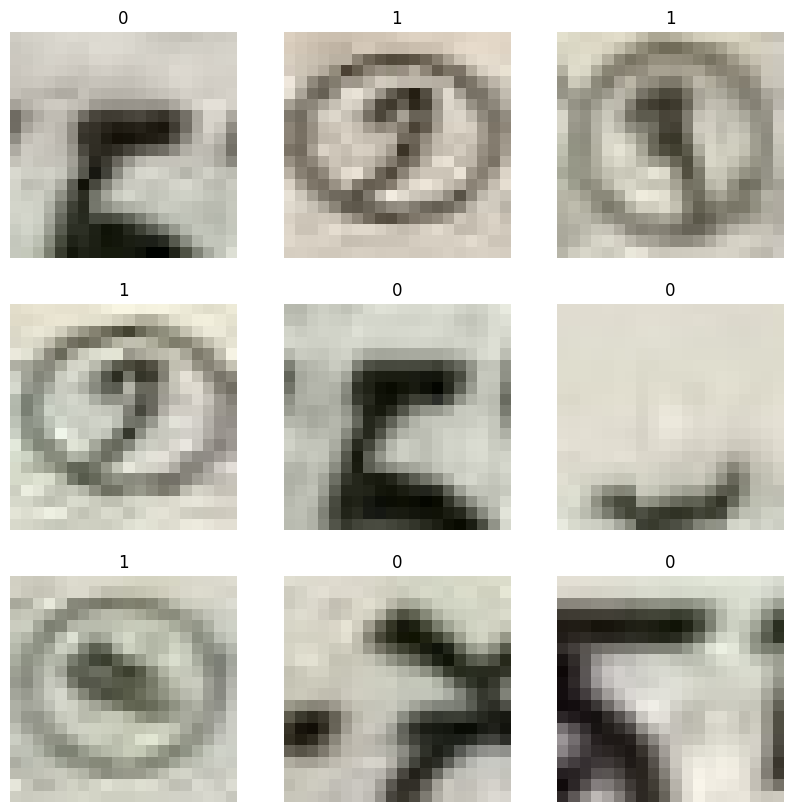

In [40]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [41]:
train_ds.class_names

['no', 'yes']

## Data Augmentation

In [59]:
data_augmentation_layers = [
    layers.RandomContrast(0.5),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2024-05-04 11:11:23.937533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


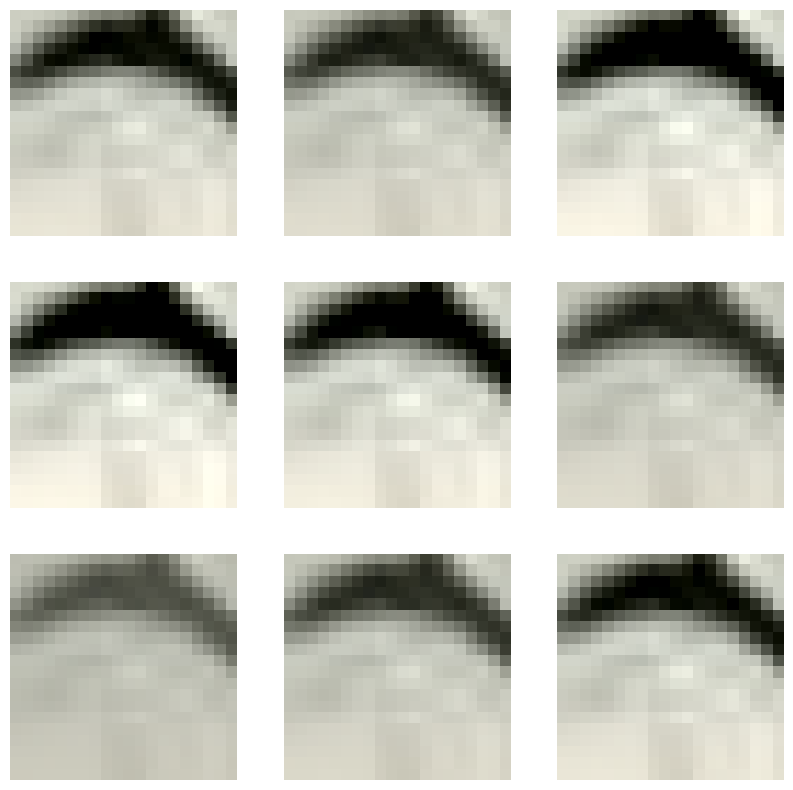

In [60]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [61]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Build Model

In [62]:
def make_model(input_shape, num_classes):
    units = 1 if num_classes == 2 else num_classes
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Rescaling(1.0 / 255),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(units, activation=None),
        ]
    )
    return model

model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,969 (78.00 KB)

 Trainable params: 19,969 (78.00 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [63]:
epochs = 25

In [64]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

In [65]:
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.5630 - loss: 0.6289 - val_acc: 0.8944 - val_loss: 0.3789
Epoch 2/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8760 - loss: 0.3604 - val_acc: 0.9770 - val_loss: 0.1827
Epoch 3/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9622 - loss: 0.1883 - val_acc: 0.9867 - val_loss: 0.0891
Epoch 4/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9787 - loss: 0.1126 - val_acc: 0.9949 - val_loss: 0.0517
Epoch 5/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9839 - loss: 0.0850 - val_acc: 0.9955 - val_loss: 0.0458
Epoch 6/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9880 - loss: 0.0632 - val_acc: 0.9938 - val_loss: 0.0315
Epoch 7/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9881 - loss: 0.0472 - val_acc: 0.9969 - val_loss: 0.0239
Epoch 8/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9915 - loss: 0.0482 - val_acc: 0.9969 - val_loss: 0.0201
Epoch 9/25
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/

## Inference

In [50]:
gen_image_path = (config.NOTE_CLASSIFIER_TRAINING_DATA / "todo").iterdir()

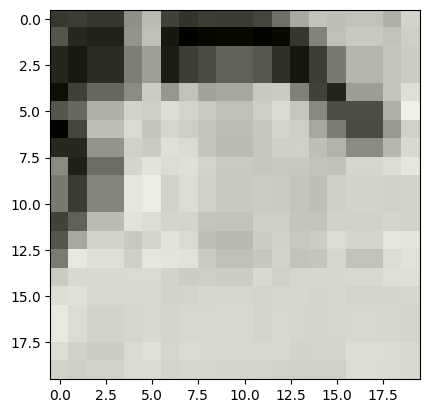

Note: 0.01%


In [57]:
def inference(image_path, model, image_size=image_size, imshow=False):
    img = keras.utils.load_img(str(image_path), target_size=image_size)
    if imshow: plt.imshow(img); plt.show()
    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array, verbose=0)
    score = float(keras.ops.sigmoid(predictions[0][0]))
    return score

image_path = next(gen_image_path)
score = inference(image_path, model, imshow=True)
print(f"Note: {100 * score:.2f}%")
if score > 0.9:
    print("It's a Note Marker")

In [58]:
model_path = Path("models") / "note_classifier" / "note_classifier.keras"
model.save(model_path)

## Classify data set

In [31]:
# model_path = Path("models") / "note_classifier" / "note_classifier.keras"
# todo_path = config.NOTE_CLASSIFIER_TRAINING_DATA / "todo"
# data_path = config.NOTE_CLASSIFIER_TRAINING_DATA / "data"
# yes_path = data_path / "yes"
# no_path = data_path / "no"

In [32]:
# model = keras.saving.load_model(model_path)

In [ ]:
# for image_fn in todo_path.iterdir():
#     if not image_fn.name.endswith(".jpg"): continue
#     print(image_fn.name)
#     score = inference(image_fn, model)
#     if score > 0.9:
#         dest_path = yes_path / image_fn.name
#     else:
#         dest_path = no_path / image_fn.name
#     shutil.move(str(image_fn), str(dest_path))